نبدأ في هذا النشاط بالنظر في مشكلات المقارنة (نماذج تشابه النصوص) باستعمال مقاييس التشابه لمعرفة مدى تشابه المدونات في عمومها. وسنستعمل *السجل اللغوي* بوصفه دراسة حالة مقارنين بيانات من لغات مختلفة تتضمن تغريدات وصفحات من الويب وويكيبيديا.

فلنبدأ بتجهيز بيئة العمل.


In [1]:
from text_analytics import TextAnalytics
import os
import pandas as pd

ai = TextAnalytics()
ai.data_dir = os.path.join("..", "data")
print("Done!")

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


Done!


وبعد ذلك نرفع مدونتنا من مجلد يتضمن نفس السجلات اللغوية وبلغات مختلفة. لنلق نظرة على الإنجليزية أولا. يحتوي عمود "النص Text" على العينات، ويعرفنا عمود "السجلات اللغوية Register" بمصدر البيانات.

In [2]:
file = os.path.join(ai.data_dir, "register", "Register.eng.gz")
df = pd.read_csv(file)
print(df)

    Register                                               Text
0         wk   was a japanese film director and screenwriter...
1         wk   at the time george ii had to accompanied trux...
2         wk   even before the building was completed there ...
3         wk   some examples of fictional colombian settings...
4         wk   red barron and vanderbilts lynn bomar were th...
..       ...                                                ...
420       cc   my name is gerri fairfield i taught for <num>...
421       cc   a bill to authorize the administrator of the ...
422       cc   protecting american taxpayers and homeowners ...
423       cc   unfunded mandates accountability act of <num>...
424       cc   department of homeland security insider threa...

[425 rows x 2 columns]


لقد كان عملنا حتى الآن مع مصنفات النصوص. فلنجرب الآن منهجية تعتمد على التصنيف أيضا. وفي هذه الحالة، سنزود المصنف بالعينات، ونستعمل متجها من تكرارات الكلمات الوظيفية للتنبؤ بالسجل اللغوي الذي تنتمي له كل عينة.

In [3]:
report = ai.shallow_classification(df, labels = "Register", features = "style", classifier = "lm")
print(report)

              precision    recall  f1-score   support

          cc       1.00      1.00      1.00        11
          tw       1.00      1.00      1.00        15
          wk       1.00      1.00      1.00        17

    accuracy                           1.00        43
   macro avg       1.00      1.00      1.00        43
weighted avg       1.00      1.00      1.00        43



ونرى هنا كيف أن المصنف يعمل جيدا. ويُظهر أن ثمة اختلافا كبيرا في قواعد اللغة الإنجليزية، بين تلك السجلات اللغوية المختلفة. غير أن ذلك ليس سؤالنا الرئيس فعلا. فبدلا من الحد القاطع بين السجلات اللغوية، من الجيد أن يكون لدينا مدى من قيم التشابه بالنظر في عدد من العينات في كل سجل. فما مدى التشابه عموما؟
 
نبدأ أدناه باختيار عينة عشوائية لأزواج من العينات؛ وذلك للحصول على مقياس متدرج لها.


In [4]:
for i in range(10):
    test1 = df.sample(n=1)
    test2 = df.sample(n=1)
    similarity = ai.get_corpus_similarity(test1.Text.tolist(), test2.Text.tolist(), language='en')
    print(test1.loc[0:,"Register"].values, test2.loc[0:,"Register"].values, similarity)


['cc'] ['cc'] 0.6840854825437811
['wk'] ['wk'] 0.6786889956015638
['cc'] ['tw'] 0.5157405470449342
['cc'] ['wk'] 0.5330282554717234
['tw'] ['wk'] 0.33113687697808186
['tw'] ['cc'] 0.39002592139561576
['tw'] ['wk'] 0.37198030500491924
['wk'] ['wk'] 0.6656120078375891
['cc'] ['tw'] 0.45400164218338174
['cc'] ['wk'] 0.5211835102270207


يولد مقياس تشابه المدونة مقياس تدرجي يقع بين القيمتين 0 و1. وتعني القيم القريبة من الصفر تباعد المدونات المقارنة فيما تغني القيم القريبة من الواحد تشابها كبيرا بينها. وقد جاء اختيار العينات عشوائيا، ولكن من المرجح أن ترى أزواجا من العينات في نفس السجل ذات تشابه أكثر من أزواج العينات من سجلات مختلفة. وهذا ما يتيح للمصنف أن يحقق هذه الدقة العالية. ولكنك ستلاحظ أيضا أن ثمة فارقا نسبيا في العلاقات بين السجلات اللغوية.

ولننعم النظر في عدد من اللغات الآن. حيث نكرر ما نقوم به على اللغات. فنرفع بيانات المدونة لكل لغة، ثم نأخذ أزواج من العينات عشوائيا حتى نصل للعدد المطلوب. وفي كل لغة نقوم بتسويةnormalize  قيم التشابه.

(يستغرق ذلك وقتا، لذا شغله ثم اقرأ الكود البرمجي أثناء معالجته)


In [5]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import random
from collections import defaultdict

full_results = []
full_results_raw = []
full_results_standardized = []

#Iterate over each language
languages = ["ara", "ell", "eng", "fra", "hin", "hun", "ind", "jpn", "por", "rus", "spa", "zho"]
for language in languages:
    
    #Load the corpus for the language
    file = os.path.join(ai.data_dir, "register", "Register." + language + ".gz")
    language_df = pd.read_csv(file)
    
    #Holder for data
    data = {}
    results = defaultdict(list)
    results_list = []
    
    #First get samples for each register
    for register in ["tw", "cc", "wk"]:
        register_df = language_df.loc[language_df["Register"] == register]
        data[register] = register_df.loc[:,"Text"].tolist()
        random.shuffle(data[register])
    
    #Collect 25 unique pairs for each combination of registers
    for register1, register2 in [("tw", "tw"), ("cc", "cc"), ("wk", "wk"), ("tw", "wk"), ("tw", "cc"), ("cc", "wk")]:
        for i in range(25):
            sample1 = data[register1].pop(0)
            sample2 = data[register2].pop(0)

            #Get the similarity
            similarity = ai.get_corpus_similarity([sample1], [sample2], language=language)
            
            #Save the similarity for the population standardization and for the specific register pair
            results_list.append(similarity)
            results[register1+"_"+register2].append(similarity)

    #Save unstandardized results
    full_results_raw.append([language, results])
    
    #Standardize across all pairs of registers
    scaler = StandardScaler()
    scaler.fit(np.array(results_list).reshape(-1, 1))
    
    #Get the average across standardized pairs for each combination
    lang_results = {"lang":language}
    lang_results_full = {"lang":language}
    
    for register_pair in results:
        
        #Standardize the results
        standardized_results = scaler.transform(np.array(results[register_pair]).reshape(-1, 1))
        mean = sum(standardized_results)/float(len(standardized_results))
        
        #Save the mean and the full results
        lang_results_full[register_pair] = standardized_results
        lang_results[register_pair] = mean[0]
    
    print(lang_results)
    full_results.append(lang_results)
    full_results_standardized.append(lang_results_full)

{'lang': 'ara', 'tw_tw': 0.9648916074382418, 'cc_cc': 1.003145554979403, 'wk_wk': 0.6835030153664562, 'tw_wk': -1.4949488347295707, 'tw_cc': -1.0235679224322392, 'cc_wk': -0.13302342062228986}
{'lang': 'ell', 'tw_tw': 1.0098855401436488, 'cc_cc': 0.8138616118364733, 'wk_wk': 0.803753944919363, 'tw_wk': -1.7113111493886373, 'tw_cc': -0.5229540041277891, 'cc_wk': -0.39323594338305784}
{'lang': 'eng', 'tw_tw': 1.4710048256008124, 'cc_cc': 0.46708100896398597, 'wk_wk': 0.5882487853152464, 'tw_wk': -1.393312788956509, 'tw_cc': -0.5070664673504788, 'cc_wk': -0.6259553635730596}
{'lang': 'fra', 'tw_tw': 1.4549554510914169, 'cc_cc': 0.6459300207149588, 'wk_wk': 0.48993822769072465, 'tw_wk': -1.5463202324128946, 'tw_cc': -0.4160247685683745, 'cc_wk': -0.6284786985158282}
{'lang': 'hin', 'tw_tw': 1.2706964165471273, 'cc_cc': 0.5153901181780437, 'wk_wk': 0.6820878979545723, 'tw_wk': -1.5206364871534837, 'tw_cc': -1.1121782304387997, 'cc_wk': 0.16464028491254054}
{'lang': 'hun', 'tw_tw': 1.1710666

وتتم تسويه تلك القيم التشابهية بحسب اللغة. فالوسط الآن هو 0. وتشير القيم الأقل من 0 إلى أن العينات مختلفة نسبيا. فيما تشير القيم الأعلى كثيرا من 0 إلى أن العينة متشابهة نسبيا.

وما يفترض أن ينتج إذن هو أن أزواج العينات التي تأتي من نفس السجل في كل اللغات (cc_cc, tw_tw, wk_wk) ذات قيم أعلى. وأن أزواج العينات التي تأتي من سجلات لغوية مختلفة (tw_wk, cc_tw, cc_wk) ذات قيم أقل.

ولنرسم تمثيلا بيانيا أوضح لإظهار النتائج. فنبدأ أولا بتنظيم النتائج وفق إطار للبيانات. ويظهر -أولا- أن جميع أزواج العينات من نفس السجل اللغوي (الذي يظهر تجانسا في مدونته) إيجابية. وكل أزواج العينات من سجلات لغوية مختلفة (التي تقف على التشابه المدوني) سلبية. وهذا ما يمكّننا إلى حد ما من التنبؤ بتنبؤات جيدة عما إذا كانت عينتان هما من نفس المدونة.


In [6]:
results_df = pd.DataFrame(full_results).set_index("lang", drop=True)
print(results_df)

         tw_tw     cc_cc     wk_wk     tw_wk     tw_cc     cc_wk
lang                                                            
ara   0.964892  1.003146  0.683503 -1.494949 -1.023568 -0.133023
ell   1.009886  0.813862  0.803754 -1.711311 -0.522954 -0.393236
eng   1.471005  0.467081  0.588249 -1.393313 -0.507066 -0.625955
fra   1.454955  0.645930  0.489938 -1.546320 -0.416025 -0.628479
hin   1.270696  0.515390  0.682088 -1.520636 -1.112178  0.164640
hun   1.171067  0.686431  0.718826 -1.702234 -0.231524 -0.642565
ind   1.142247  0.693311  0.750616 -1.773053 -0.447700 -0.365420
jpn   1.402519  0.571595  0.180061 -1.564412  0.260033 -0.849796
por   1.431593  0.609898  0.583553 -0.977271 -1.394942 -0.252831
rus   1.229239  0.694245  0.735802 -1.549404 -0.336852 -0.773031
spa   1.470863  0.531216  0.604231 -1.524959 -0.421418 -0.659933
zho   1.321955  0.647645  0.570089 -1.203909 -0.270400 -1.065381


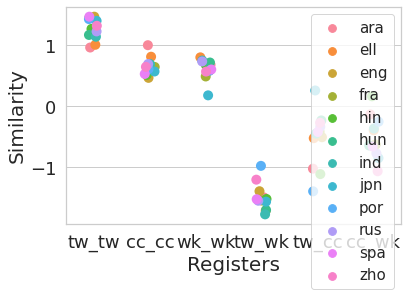

In [13]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
sns.set_theme(style="whitegrid")

graph_df = results_df.loc[:,["tw_tw", "cc_cc", "wk_wk", "tw_wk", "tw_cc", "cc_wk"]].stack().to_frame().reset_index() 

graph_df.columns = ["Language", "Registers", "Similarity"]

ax = sns.stripplot(y="Similarity", x="Registers", hue="Language", data=graph_df, size=10)

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27
rcParams['font.size'] = 15
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.legend(title='', fontsize=15, title_fontsize=20)
plt.xlabel("Registers",size=20)
plt.ylabel("Similarity",size=20)
plt.tick_params(axis='both', which='major', labelsize=18)

ولكن ما مدى دقة هذا المقياس في التشابه المدوني؟ لقد اختبرنا المقياس باستعمال حد فاصل بسيط عند التنبؤ. وبعض الأزواج من المدونات هي من نفس السجلات اللغوية، وبعضها الآخر من سجلات لغوية مختلفة. فهل ثمة حد فاصل لكل لغة يمكّننا من التنبؤ بتنبؤات دقيقة؟ هيا نستكشف.

In [8]:
for language, results in full_results_raw:
    
    #Divide pairs into same or different registers
    same_register = results["tw_tw"] + results["cc_cc"] + results["wk_wk"]
    cross_register = results["cc_wk"] + results["tw_wk"] + results["tw_cc"]
    
    #Set a threshold halfway between the lowest and highest values of each
    threshold = (min(same_register) + max(cross_register)) / 2.0
    counter = 0
    
    #Errors from different register pairs being too similar
    for value in cross_register:
        if value > threshold:
            counter += 1
    
    #Errors from same register pairs being too different
    for value in same_register:
        if value < threshold:
            counter += 1
          
    total = len(same_register+cross_register)
    
    print(language, (total-counter)/total)

ara 0.9333333333333333
ell 1.0
eng 0.9133333333333333
fra 0.9866666666666667
hin 0.9533333333333334
hun 0.9866666666666667
ind 1.0
jpn 0.8133333333333334
por 0.9
rus 0.9733333333333334
spa 0.9733333333333334
zho 0.9133333333333333


وهذا يوضح لنا الدقة (صحيح %). إنه مقياس دقيق يشبه إلى حد ما مقياس درجة-ف هنا؛ لأن ثمة نفس العدد من العينات في كل تصنيف. ومن ثم النقطة المهمة هنا هي أن المقياس دقيق جدا مع معظم اللغات عند التنبؤ بالتصنيف، رغم أن هدفنا هو الحصول على مقياس متصل لمقارنة المدونات.

وأخيرا، لنلق نظرة على التجانس داخل النفس السجل اللغوي. بعبارة أخرى، ما مدى اتساق المدونات ذات المصدر الواحد وثباتها؟ سنستعمل مقياس التشابه المدوني كأساس للنظر في اتساق بيانات المصادر الرقمية في تلك اللغات.


In [9]:
homogeneity = []
for lang in full_results_standardized:   
    for register_pair in ["tw_tw", "cc_cc", "wk_wk"]:
        for value in lang[register_pair]:
            homogeneity.append([lang["lang"], register_pair[:2], value[0]])

homogeneity_df = pd.DataFrame(homogeneity, columns = ["Language", "Register", "Value"])
print(homogeneity_df)

    Language Register     Value
0        ara       tw  0.995572
1        ara       tw  0.849583
2        ara       tw  0.890770
3        ara       tw  0.901390
4        ara       tw  0.896998
..       ...      ...       ...
895      zho       wk  0.907744
896      zho       wk  0.375998
897      zho       wk  1.136392
898      zho       wk  0.807920
899      zho       wk  0.787468

[900 rows x 3 columns]


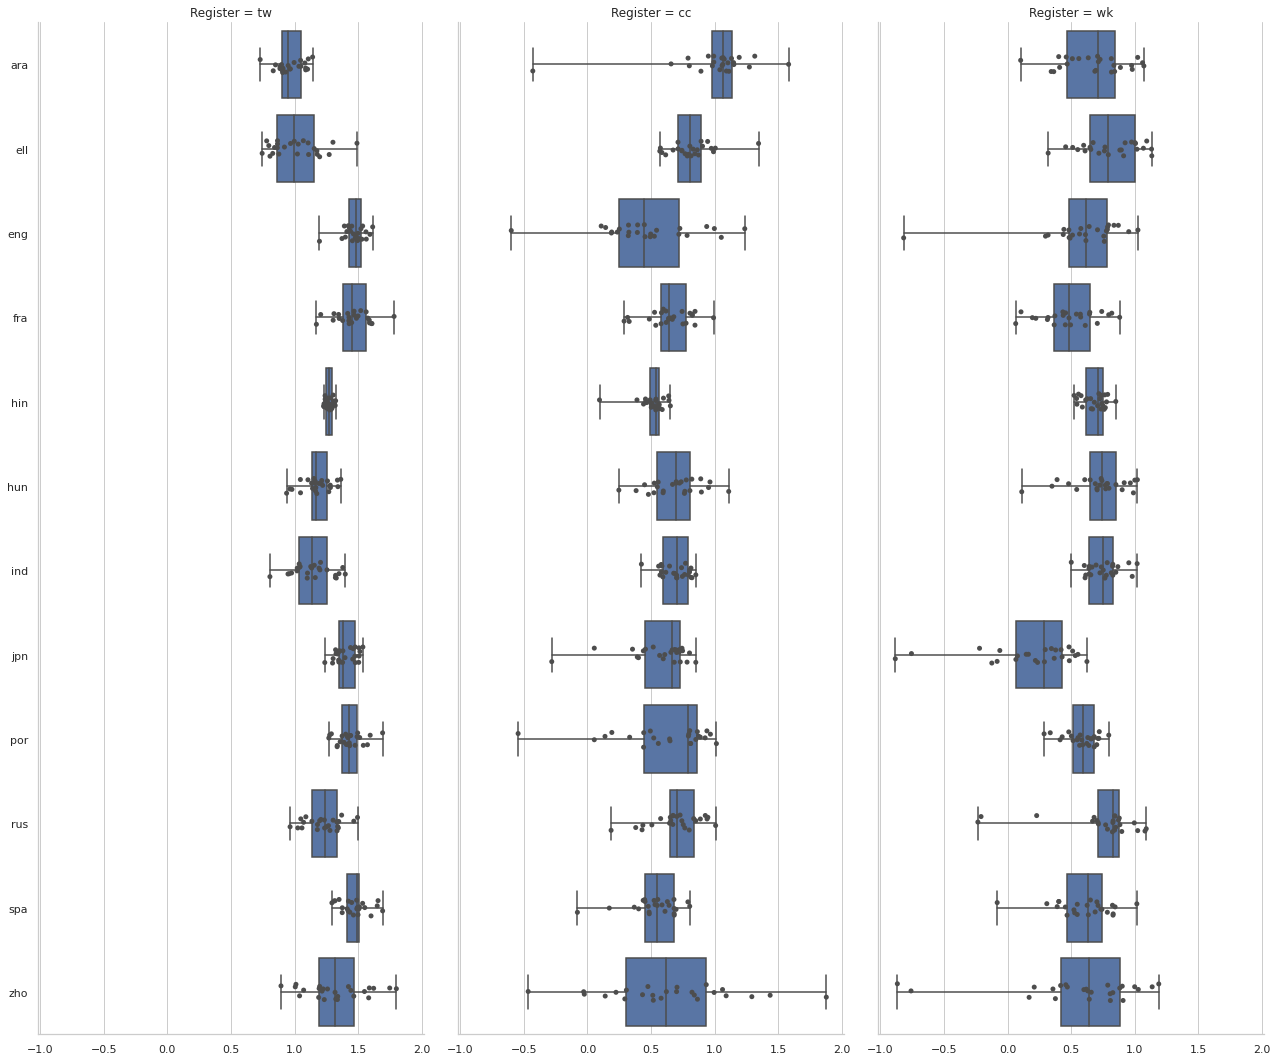

In [10]:
g = sns.FacetGrid(homogeneity_df, col="Register", height=15, aspect = 0.4)

g.map_dataframe(sns.boxplot, x="Value", y="Language", data=homogeneity_df, whis=np.inf)
g.map_dataframe(sns.stripplot, x="Value", y="Language", data=homogeneity_df, color=".3")

إذن هذا يوضح لنا الاتساق في كل سجل لغوي بحسب اللغة. فحين تتجمّع قيم التشابه معا، فإن ذلك يعني أن المدونة متجانسة جدا. ولكن حين تتناثر القيم على مدى واسع فستكون أكثر تنوعا واختلافا. وأدناه مثلنا ذلك برسم أصغر.

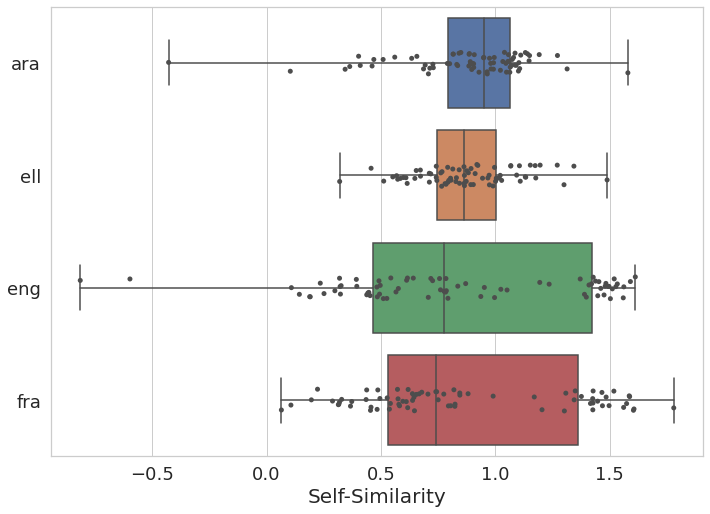

In [11]:
reduced_df = homogeneity_df.loc[homogeneity_df['Language'].isin(["ara", "ell", "eng", "fra"])]
reduced_df.loc[reduced_df['Register'] == "tw"]                                                               

sns.boxplot(x="Value", y="Language", data=reduced_df, whis=np.inf)
sns.stripplot(x="Value", y="Language", data=reduced_df, color=".3")
plt.xlabel("Self-Similarity",size=20)
plt.ylabel("",size=20)
plt.tick_params(axis='both', which='major', labelsize=18)